# Simulated Roman Time Domain Survey Data

## Learning Goals:

By the end of this tutorial, you will:

1. learn more about the "observations" that make up the simulated Roman TDS preview.
2. learn how to find the locations of simulated supernovae in the preview data.
3. learn how to create aligned cutouts of simulated Roman images.
4. learn how to make an animated gif from these cutouts.

## Install and Import required modules

In [1]:
# Install libraries if necessary by uncommenting the following
# !pip install astropy matplotlib numpy pandas pyarrow s3fs scipy

In [2]:
# Import modules
import warnings

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.nddata.utils import NoOverlapError
from astropy.table import Table
from astropy.wcs import WCS, FITSFixedWarning
from matplotlib import animation
from scipy.ndimage import rotate

# Needed to access data in the cloud
import s3fs
s3 = s3fs.S3FileSystem(anon=True) # create an S3 client

# Filter out the FITSFixedWarning, which is consequenceless and gets thrown every time you deal with a WCS
# in a Roman openuniverse simulated image using astropy.
warnings.simplefilter('ignore',category=FITSFixedWarning)

## Define a module to get the date (mjd) of a particular pointing.

In [3]:
def get_mjd(pointing,
            obseq_path=f's3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/Roman_TDS_obseq_11_6_23.fits'):

    """
    Retrieve MJD of a given pointing.

    :param pointing: Pointing ID.
    :type pointing: int
    :param obseq_path: Path to obseq file Roman_TDS_obseq_11_6_23.fits.
    :type obseq_path: str, optional
    :return: MJD of specified pointing.
    :rtype: float
    """

    with fits.open(obseq_path, fsspec_kwargs={"anon": True}) as obs:
        obseq = Table(obs[1].data)
    mjd = float(obseq['date'][int(pointing)])

    return mjd

## Define a module to create an animated gif from a collection of cutouts.

In [4]:
def animate_stamps(stamps,savepath,no_whitespace=True,
                   labels=[],labelxy=(0.05,0.95),
                   **kwargs):
    """
    Make an animation of a sequence of image stamps.

    :param stamps: Must be in chronological order.
    :type stamps: List of stamps from get_stamps or get_object_instances.
    :param savepath: Path to save gif.
    :type savepath: str
    """

    if no_whitespace:
        with_whitespace = np.invert(np.any((np.isnan(np.array(stamps))), axis=(1,2))) # NOTE: Your first axis (first indexing value) should return one stamp. e.g. stamps[0] is the first stamp.
        idx_whitespace = np.where(with_whitespace)[0]
        stamps = np.array(stamps)[idx_whitespace]
        if len(labels) != 0:
            labels = np.array(labels)[idx_whitespace]

    fig, ax = plt.subplots(figsize=(5,5))
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.xticks([])
    plt.yticks([])

    im = ax.imshow(stamps[0], animated=True)

    if len(labels) != 0:
        txt = ax.text(labelxy[0],labelxy[1],labels[0],animated=True,color='white',transform=ax.transAxes,va='top',ha='left',**kwargs)

    def animate(i):
        im.set_array(stamps[i])
        if len(labels) != 0:
            txt.set_text(labels[i])

            return [im] + [txt]
        else:
            return [im]

    writer = animation.PillowWriter()
    anim = animation.FuncAnimation(fig, animate, interval=600, frames=len(stamps))
    anim.save(savepath, writer=writer)

## Read in the Observation Sequence File to learn more about the "observations" that make up the simulated Roman Time Domain Survey.

In [5]:
# Read in the (simulated) Observation Sequence File.

BUCKET_NAME = 'nasa-irsa-simulations'
ROMAN_PREFIX = 'openuniverse2024/roman/preview'

ROMAN_TDS_PATH = f'{ROMAN_PREFIX}/RomanTDS'
FILENAME = 'Roman_TDS_obseq_11_6_23.fits'
OBSEQ_PATH = f's3://{BUCKET_NAME}/{ROMAN_TDS_PATH}/{FILENAME}'

obseq_hdu = fits.open(OBSEQ_PATH, fsspec_kwargs={"anon": True})
obseq = pd.DataFrame(obseq_hdu[1].data)

print(obseq)

             ra      dec filter  exptime         date        pa
0       7.60523 -45.6541   R062  161.025  62000.02139   0.00000
1       7.60523 -44.8337   R062  161.025  62000.02407   0.00000
2       7.60523 -44.0134   R062  161.025  62000.02674   0.00000
3       7.60523 -43.1930   R062  161.025  62000.02941   0.00000
4       7.60523 -42.3727   R062  161.025  62000.03209   0.00000
...         ...      ...    ...      ...          ...       ...
57360  11.81670 -44.9265   K213  901.175  63563.01290  19.72602
57361  11.53980 -44.1543   K213  901.175  63563.02420  19.72602
57362  11.26290 -43.3821   K213  901.175  63563.03540  19.72602
57363  10.98600 -42.6099   K213  901.175  63563.04660  19.72602
57364  10.70920 -41.8377   K213  901.175  63563.05790  19.72602

[57365 rows x 6 columns]


## What is the spatial and temporal coverage of the openuniverse2024 Roman TDS data preview?

In [6]:
# Find the ranges of RA, Dec, and date listed in the observation sequence file.

ra_min, dec_min = obseq[['ra','dec']].min()
ra_max, dec_max = obseq[['ra','dec']].max()
mjd_min = obseq['date'].min()
mjd_max = obseq['date'].max()

print("ra_min, ra_max:", ra_min, ra_max)
print("mjd_min, mjd_max:", mjd_min, mjd_max)

ra_min, ra_max: 6.97879 12.0204
mjd_min, mjd_max: 62000.02139 63563.0579


## Read in the Supernova Analysis (SNANA) file.

In [7]:
parquet_file = f's3://{BUCKET_NAME}/{ROMAN_PREFIX}/roman_rubin_cats_v1.1.2_faint/snana_10307.parquet'
transients = pd.read_parquet(parquet_file, filesystem=s3)

## Let's find a relatively nearby SN Ia that lies within the region of the data preview.

In [8]:
#List the unique models in the SNANA file.
unique_models = pd.Series(transients['model_name']).drop_duplicates().tolist()
unique_models

['FIXMAG',
 'NON1ASED.KN-K17',
 'NON1ASED.PISN-STELLA-HECORE',
 'NON1ASED.PISN-STELLA-HYDROGENIC',
 'NON1ASED.SLSN-I-BBFIT',
 'NON1ASED.V19_CC+HostXT_WAVEEXT',
 'SALT3.NIR_WAVEEXT',
 'NON1ASED.SNIax',
 'NON1ASED.TDE-BBFIT']

In [9]:
# Most of the models are non SNIa (NON1ASED).
# Choose only the SNIa
sn1a = transients[transients['model_name'] == 'SALT3.NIR_WAVEEXT'] # SNe Ia only.
print('Number of SN1a in SNANA file: ', len(sn1a))

Number of SN1a in SNANA file:  10369


In [10]:
# Choose the SNIa that overlap with the spatial extent of the OpenUniverse2024 Roman TDS data preview.
ra_mask = np.logical_and(sn1a['ra'] > ra_min, sn1a['ra'] < ra_max)
dec_mask = np.logical_and(sn1a['dec'] > dec_min, sn1a['dec'] < dec_max)
mjd_mask = np.logical_and(sn1a['start_mjd'] > mjd_min, sn1a['end_mjd'] < mjd_max)
all_mask = np.logical_and.reduce((ra_mask,dec_mask,mjd_mask))
preview_sn1a = sn1a[all_mask]
print('Number of SNIa in OpenUniverse2024 data preview:', len(preview_sn1a))

Number of SNIa in OpenUniverse2024 data preview: 6718


In [11]:
# Choose the SNIa in the data preview that are nearby, at redshifts less than 0.7.
nearby_preview_sn1a = preview_sn1a[preview_sn1a['z_CMB'] < 0.7]
print('Number of nearby SNIa in OpenUniverse2024 data preview:', len(nearby_preview_sn1a))

Number of nearby SNIa in OpenUniverse2024 data preview: 573


In [12]:
# Let's choose SN 20000808.
oid = 20000808
chosen_object = nearby_preview_sn1a[nearby_preview_sn1a['id'] == oid]
ra = chosen_object.get('ra')
dec = chosen_object.get('dec')
ra, dec = 9.619282, -44.313894
coord = SkyCoord(ra*u.deg, dec*u.deg)

## Read in the auxiliary file that lists the simulated Roman TDS images covering the chosen SNIa.

In [13]:
# The auxiliary file contains all the images this thing is in.
# If you need to download this file, see https://irsa.ipac.caltech.edu/docs/notebooks/.
csvfile = './openuniverse2024_roman_demodata_20000808_instances.csv'
instances = pd.read_csv(csvfile, usecols=['filter','pointing','sca'])
instances

,filter,pointing,sca
0,R062,407,7
1,R062,4257,10
2,R062,4647,6
3,R062,6182,5
4,R062,8112,15
5,R062,9652,17
6,R062,11197,1
7,R062,11582,1
8,R062,15037,8
9,R062,16962,11


## Create cutouts of the chosen SNIa in the band of your choice.

In [14]:
band = 'R062'
instances = instances[instances['filter'] == band]

In [15]:
#Make the cutouts; this will take a couple of minutes.
stamps = []
mjd = []
for i, row in enumerate(instances.itertuples()):
    band, pointing, sca = row[1], row[2], row[3]
    imgpath = f's3://{BUCKET_NAME}/{ROMAN_TDS_PATH}/images/simple_model/{band}/{pointing}/Roman_TDS_simple_model_{band}_{pointing}_{sca}.fits.gz'
    print(imgpath)
    with fits.open(imgpath, fsspec_kwargs={"anon": True}) as hdu:
        img = hdu[1].data
        header = hdu[0].header
        wcs = WCS(header)
        x, y = wcs.world_to_pixel(coord)

        # Manually rotate the images so they are all aligned.
        CDmat = np.array([header['CD1_1'], header['CD1_2'],
                          header['CD2_1'], header['CD2_2']]).reshape(2,2)

        orientation = hdu[0].header['ORIENTAT']

        # These chips are "flipped".
        if sca % 3 == 0:
            orientation += 180

        # Build rotation matrix.
        CD1_1_rot = np.cos(-orientation*np.pi/180)
        CD1_2_rot = -np.sin(-orientation*np.pi/180)
        CD2_1_rot = np.sin(-orientation*np.pi/180)
        CD2_2_rot = np.cos(-orientation*np.pi/180)

        RotMat = np.array([CD1_1_rot, CD1_2_rot,
                          CD2_1_rot, CD2_2_rot]).reshape(2,2)

        RotMat_inv = np.array([CD1_1_rot, -CD1_2_rot,
                              -CD2_1_rot, CD2_2_rot]).reshape(2,2)

        # Apply rotation to the CDi_j header keywords.
        CDmat_rot = np.dot(CDmat,RotMat_inv)

        # Update header.
        header['CD1_1'], header['CD1_2'] = CDmat_rot[0]
        header['CD2_1'], header['CD2_2'] = CDmat_rot[1]
        header['ORIENTAT'] -= orientation

        # Rotate the image.
        rot_img = rotate(img,angle=orientation,reshape=False,cval=np.nan)
        hdu[1].data = rot_img

        rot_wcs = WCS(header)

        try:
            # Make cutout around SN Ia location.
            cutout = Cutout2D(rot_img,coord,100,wcs=rot_wcs,mode='partial')
            stamps.append(cutout.data)
            mjd.append(get_mjd(pointing))
        except NoOverlapError:
            pass

s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/407/Roman_TDS_simple_model_R062_407_7.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/4257/Roman_TDS_simple_model_R062_4257_10.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/4647/Roman_TDS_simple_model_R062_4647_6.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/6182/Roman_TDS_simple_model_R062_6182_5.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/8112/Roman_TDS_simple_model_R062_8112_15.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/9652/Roman_TDS_simple_model_R062_9652_17.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/11197/Roman_TDS_simple_model_R062_11197_1.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/11582/Roman_TDS_simple_model_R062_11582_1.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/15037/Roman_TDS_simple_model_R062_15037_8.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/16962/Roman_TDS_simple_model_R062_16962_11.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/18502/Roman_TDS_simple_model_R062_18502_10.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/18507/Roman_TDS_simple_model_R062_18507_6.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/20812/Roman_TDS_simple_model_R062_20812_6.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/21592/Roman_TDS_simple_model_R062_21592_18.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/21977/Roman_TDS_simple_model_R062_21977_17.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/22357/Roman_TDS_simple_model_R062_22357_15.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/23512/Roman_TDS_simple_model_R062_23512_17.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/25442/Roman_TDS_simple_model_R062_25442_1.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/27367/Roman_TDS_simple_model_R062_27367_13.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/28512/Roman_TDS_simple_model_R062_28512_7.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/32362/Roman_TDS_simple_model_R062_32362_10.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/32752/Roman_TDS_simple_model_R062_32752_6.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/34287/Roman_TDS_simple_model_R062_34287_5.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/36217/Roman_TDS_simple_model_R062_36217_15.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/37757/Roman_TDS_simple_model_R062_37757_17.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/39302/Roman_TDS_simple_model_R062_39302_1.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/39687/Roman_TDS_simple_model_R062_39687_1.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/43142/Roman_TDS_simple_model_R062_43142_8.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/45067/Roman_TDS_simple_model_R062_45067_11.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/46607/Roman_TDS_simple_model_R062_46607_10.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/46612/Roman_TDS_simple_model_R062_46612_6.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/48917/Roman_TDS_simple_model_R062_48917_6.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/49697/Roman_TDS_simple_model_R062_49697_18.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/50082/Roman_TDS_simple_model_R062_50082_17.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/50462/Roman_TDS_simple_model_R062_50462_15.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/51617/Roman_TDS_simple_model_R062_51617_17.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/53547/Roman_TDS_simple_model_R062_53547_1.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/55472/Roman_TDS_simple_model_R062_55472_13.fits.gz


s3://nasa-irsa-simulations/openuniverse2024/roman/preview/RomanTDS/images/simple_model/R062/56617/Roman_TDS_simple_model_R062_56617_7.fits.gz


## Make an animated gif out of the cutouts.

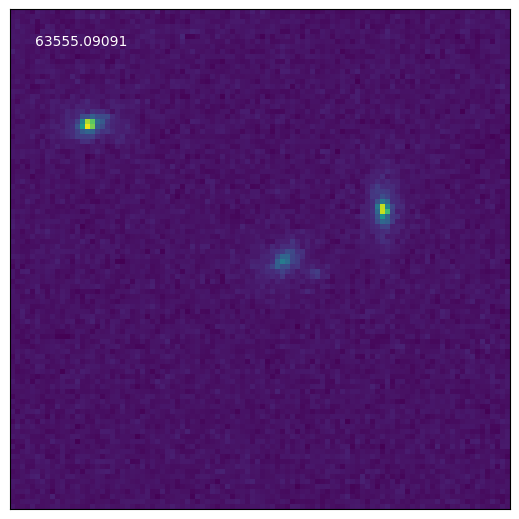

In [16]:
savepath = f'SN{oid}.gif'
savepath
animate_stamps(stamps,savepath,labels=mjd)

![animated gif](SN20000808.gif)

## About this notebook

- Author: Lauren Aldoroty (laurenaldoroty@gmail.com) with minor subsequent modifications to match repository style
- Contact: https://irsa.ipac.caltech.edu/docs/help_desk.html
- Updated: 2024-06-10